# GMM for handwritten digits recognition and generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture

## Importing the dataset

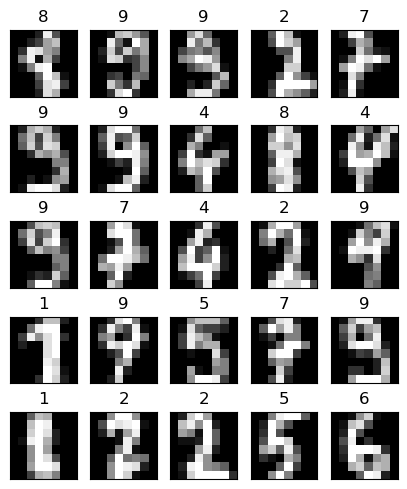

In [2]:
digits = load_digits()
fig, axs = plt.subplots(5, 5, figsize=(5,6))
idxs = np.random.choice(digits.data.shape[0], 25)

for i, idx in enumerate(idxs):
    ax = axs[i//5,i%5]
    ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax.imshow(digits.images[idx], cmap="gray")
    ax.set_title(digits.target[idx])
    
plt.show()

## Partitioning the dataset

In [3]:
train_data, test_data, train_target, test_target = train_test_split(digits.data, digits.target, test_size=0.2,
                                                    random_state=0, stratify=digits.target)

## Applying PCA for dimensionality reduction

In [4]:
pca = PCA(n_components = 30)

In [5]:
low_dimensional_train_data = pca.fit_transform(train_data)
low_dimensional_test_data = pca.transform(test_data)

In [6]:
print(f"Amount of variance captured: {round(sum(pca.explained_variance_ratio_*100))}%")

Amount of variance captured: 96%


## GMM Clustering on the low dimensional data

### Choosing the number of components in order to maximize the test accuracy

In [7]:
def get_cluster_to_digit_mapping(i, target, labels):
    """
    Returns the digit corresponding to a given cluster index.
    """
    cluster_labels = target[labels == i]
    values, counts = np.unique(cluster_labels, return_counts=True)
    return values[counts.argmax()]

In [8]:
def get_prediction_accuracy(n_components, dp=False):
    """
    Returns the prediction accuracy for the test
    and train data given the number of components of the GMM.
    """
    if dp:
        gm = BayesianGaussianMixture(n_components = n_components, random_state=12345).fit(low_dimensional_train_data)
    else:
        gm = GaussianMixture(n_components = n_components, random_state=12345).fit(low_dimensional_train_data)
    prediction_train = gm.predict(low_dimensional_train_data)
    label_to_digit = np.array([get_cluster_to_digit_mapping(i, train_target, prediction_train)
                                for i in range(gm.n_components)])
    digits_prediction_train = np.take(label_to_digit, prediction_train)
    train_accuracy = sum(train_target == digits_prediction_train) / train_target.shape[0]
    
    prediction_test = gm.predict(low_dimensional_test_data)
    digits_prediction_test = np.take(label_to_digit, prediction_test)
    test_accuracy = sum(test_target == digits_prediction_test) / test_target.shape[0]
    return train_accuracy, test_accuracy

vectorized_get_prediction_accuracy = np.vectorize(get_prediction_accuracy)

n_components = np.arange(10, 1000, 50, dtype="object")
train_accuracies, test_accuracies = vectorized_get_prediction_accuracy(n_components)

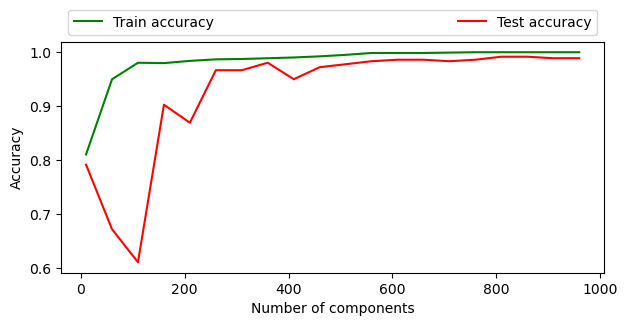

In [9]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(n_components, train_accuracies, c="green", label = "Train accuracy") 
ax.plot(n_components, test_accuracies, c="red", label = "Test accuracy") 
ax.legend(bbox_to_anchor=(0,1,1,.1),ncol=2,
          mode="expand",  loc="lower left")
_ = ax.set_ylabel("Accuracy")
_ = ax.set_xlabel("Number of components")
#  fig.savefig("fitting.png")

The test accuracy drops but then grows again. That is because this model is equivalent to applying KNN with n_neighbors=1 when the number of components of the mixture grows. 

In [10]:
gm = GaussianMixture(n_components=20, random_state=12345).fit(low_dimensional_train_data)

In [11]:
prediction_train = gm.predict(low_dimensional_train_data)
label_to_digit = np.array([get_cluster_to_digit_mapping(i, train_target, prediction_train) for i in range(gm.n_components)])

### Visualizing the model in 2D

In [12]:
pca_2d = PCA(n_components = 2)
train_data_2d = pca_2d.fit_transform(low_dimensional_train_data)
covariances_2d = pca_2d.components_ @ gm.covariances_ @ pca_2d.components_.T
means_2d = gm.means_ @ pca_2d.components_.T

In [13]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))

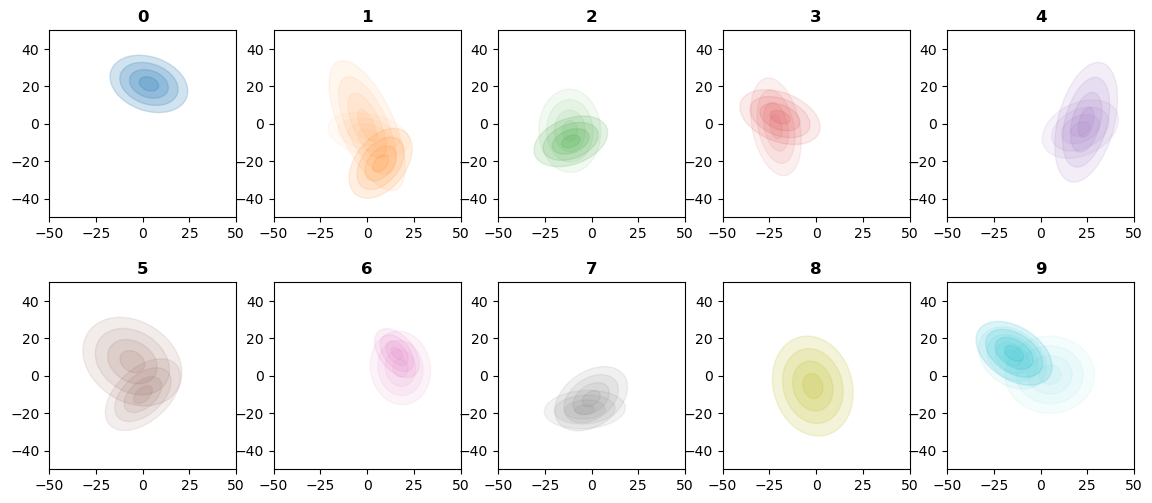

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(14,6), subplot_kw=dict(xlim = (-50, 50), ylim = (-50,50), aspect="equal", adjustable="box"))
ax.scatter(*means_2d.T, c=label_to_digit, cmap="tab10")

w_factor = 0.2 / gm.weights_.max()
cmap = plt.colormaps.get_cmap("tab10")
for i, (center, covariance, w) in enumerate(zip(means_2d, covariances_2d, gm.weights_)):
    digit = label_to_digit[i]
    ax = axs[digit//5, digit%5]
    ax.set_title(f"{digit}", fontweight="bold")
    color = cmap.colors[digit]
    draw_ellipse(center, covariance, ax = ax, alpha=w * w_factor, color = color)
    #ax.scatter(*means_2d[i,:].T, color=color)
plt.show()

### Prediction of the model on the train data

In [15]:
digits_prediction_train = np.take(label_to_digit, prediction_train)

In [16]:
print(f"Accuracy: {sum(train_target == digits_prediction_train) / train_target.shape[0]}")

Accuracy: 0.9151009046624913


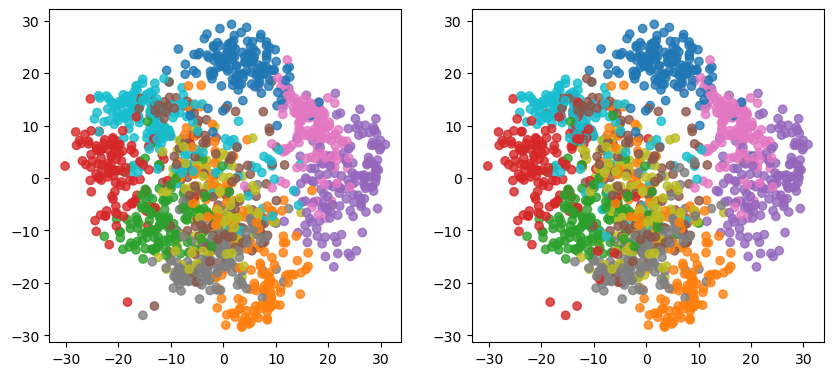

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (10, 10))
axs[0].set_aspect('equal', adjustable='box'), axs[1].set_aspect('equal', adjustable='box')

axs[0].scatter(*train_data_2d.T, c=digits_prediction_train, cmap="tab10", alpha=0.8)
axs[1].scatter(*train_data_2d.T, c=train_target, cmap="tab10", alpha=0.8)

plt.show()

### Prediction of the model on the test data

In [18]:
prediction_test = gm.predict(low_dimensional_test_data)
digits_prediction_test = np.take(label_to_digit, prediction_test)

In [19]:
 print(f"Accuracy: {sum(test_target == digits_prediction_test) / test_target.shape[0]}")

Accuracy: 0.8888888888888888


In [20]:
test_data_2d = pca_2d.fit_transform(low_dimensional_test_data)

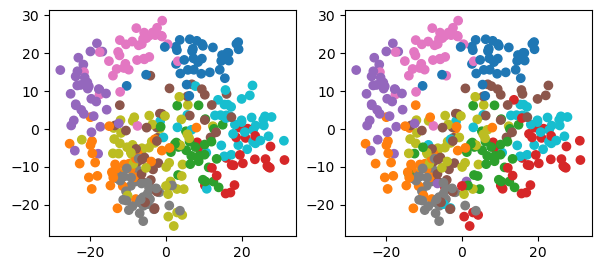

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (7, 7))
axs[0].set_aspect('equal', adjustable='box'), axs[1].set_aspect('equal', adjustable='box')

axs[0].scatter(*test_data_2d.T, c=digits_prediction_test, cmap="tab10")
axs[1].scatter(*test_data_2d.T, c=test_target, cmap="tab10")
plt.show()

## Generating new handwritten digits from the obtained model

In [22]:
low_dimensional_sample_data, sample_target = gm.sample(100)
sample_data = pca.inverse_transform(low_dimensional_sample_data)
sample_target = np.take(label_to_digit, sample_target)

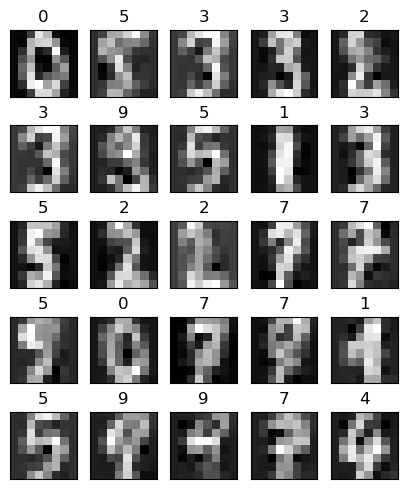

In [23]:
fig, axs = plt.subplots(5, 5, figsize=(5,6))
idxs = np.random.choice(sample_data.shape[0], 25)

for i, idx in enumerate(idxs):
    ax = axs[i//5,i%5]
    ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax.imshow(sample_data[idx].reshape(8,8), cmap="gray")
    ax.set_title(sample_target[idx])
    
plt.show()